In [30]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import matplotlib.pyplot as plt
import sqlite3
from sklearn.preprocessing import MinMaxScaler

In [2]:
from matplotlib import font_manager, rc
import matplotlib
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family=font_name)

In [3]:
seoul_district = pd.read_csv("C:/Users/ITSC/Desktop/MiniPrj2/Git/Data/seoul_district.csv")

In [4]:
seoul_district.head()

,Unnamed: 0,자치구,중대형 지하1층,중대형 1층,중대형 2층,중대형 3층,중대형 4층,중대형 5층,중대형 6-10층,소형 지하1층,소형 1층,소형 2층,면적 (km²)
0,0,강남구,22.13,64.54,32.0,25.54,23.36,22.50,21.64,29.43,64.67,33.71,39.50
1,1,강동구,11.10,47.20,20.5,15.20,13.50,12.00,12.10,0.00,56.10,24.70,24.59
2,2,강북구,13.17,45.93,18.9,15.43,12.50,12.93,14.33,13.00,42.60,17.80,23.60
3,3,강서구,10.70,35.20,16.3,14.80,12.30,10.10,9.00,6.20,28.70,13.60,41.45
4,4,관악구,18.40,72.80,28.9,21.95,19.65,21.25,18.05,13.80,65.75,30.85,29.57


In [7]:
subway_2401_df = pd.read_csv("C:/Users/ITSC/Desktop/MiniPrj2/Git/Data/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv")

In [8]:
subway_2401_df.head()

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,202402,1호선,동대문,701,8,9527,1753,7632,5598,11791,...,8195,682,2719,4,226,0,0,0,0,20240303
1,202402,1호선,동묘앞,182,2,2391,775,3042,3999,6763,...,3988,138,2107,3,275,0,0,0,0,20240303
2,202402,1호선,서울역,578,17,6983,7715,11521,49271,36199,...,12382,4115,3348,79,199,0,0,0,0,20240303
3,202402,1호선,시청,74,2,1878,4266,3581,20312,6851,...,3487,563,1003,8,40,0,0,0,0,20240303
4,202402,1호선,신설동,313,25,7586,1784,8387,7403,18494,...,7942,334,2370,5,36,0,0,0,0,20240303


In [9]:
sub_station_df = pd.read_csv("C:/Users/ITSC/Desktop/MiniPrj2/Git/Data/서울시 역사마스터 정보.csv")

In [10]:
sub_station_df.head()

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868
3,4928,고촌,김포골드라인,37.601243,126.770345
4,4927,풍무,김포골드라인,37.612488,126.732387


## 지하철역 목록 전처리

In [9]:
def coord_gu(coord):
    curl = f"https://naveropenapi.apigw.ntruss.com/map-reversegeocode/v2/gc?request=coordsToaddr&coords={coord[0]},{coord[1]}&sourcecrs=epsg:4326&output=json&orders=legalcode,admcode"
    headers = {"X-NCP-APIGW-API-KEY-ID" : "0tsfmn4cxb",
              "X-NCP-APIGW-API-KEY" : "WNsIKG0477VBDWIIqWiS51oF0Y59MNWOSZe0jntZ"}
    
    res = requests.get(curl, headers)
    
    return res

In [10]:
def combine_columns(row):
    return [row['경도'], row['위도']]

# apply 메서드를 사용하여 새로운 열 생성
sub_station_df['combined'] = sub_station_df.apply(combine_columns, axis=1)

In [26]:
tqdm.pandas()

In [27]:
sub_station_df["address"] = sub_station_df["combined"].progress_map(coord_gu)

100%|██████████| 771/771 [03:04<00:00,  4.18it/s]


In [28]:
sub_station_df["address"] = sub_station_df["address"].map(lambda x: x.json()["results"][0]["region"]["area2"]["name"])

In [29]:
sub_station_df2 = sub_station_df.loc[sub_station_df["address"].isin(seoul_district["자치구"])]

In [30]:
sub_station_df2 = sub_station_df2.drop_duplicates(subset=['역사명'])

In [31]:
sub_station_df2 = sub_station_df2.reset_index(drop = True)

In [32]:
sub_station_df2.head()

,역사_ID,역사명,호선,위도,경도,combined,address
0,9995,강일,5호선,37.557490,127.175930,"[127.17593, 37.55749]",강동구
1,4929,김포공항,김포골드라인,37.562360,126.801868,"[126.801868, 37.56236]",강서구
2,4713,신설동,우이신설선,37.576095,127.023242,"[127.023242, 37.576095]",동대문구
3,4708,솔샘,우이신설선,37.620238,127.013626,"[127.013626, 37.620238]",강북구
4,4707,삼양사거리,우이신설선,37.621337,127.020473,"[127.020473, 37.621337]",강북구


In [33]:
sub_station_df2 = sub_station_df2.iloc[:, [0, 1, 5, 6]]

In [34]:
sub_station_df2.head()

,역사_ID,역사명,combined,address
0,9995,강일,"[127.17593, 37.55749]",강동구
1,4929,김포공항,"[126.801868, 37.56236]",강서구
2,4713,신설동,"[127.023242, 37.576095]",동대문구
3,4708,솔샘,"[127.013626, 37.620238]",강북구
4,4707,삼양사거리,"[127.020473, 37.621337]",강북구


## 승하차 기록 전처리 1

In [35]:
subway_2401_df.head()

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,202402,1호선,동대문,701,8,9527,1753,7632,5598,11791,...,8195,682,2719,4,226,0,0,0,0,20240303
1,202402,1호선,동묘앞,182,2,2391,775,3042,3999,6763,...,3988,138,2107,3,275,0,0,0,0,20240303
2,202402,1호선,서울역,578,17,6983,7715,11521,49271,36199,...,12382,4115,3348,79,199,0,0,0,0,20240303
3,202402,1호선,시청,74,2,1878,4266,3581,20312,6851,...,3487,563,1003,8,40,0,0,0,0,20240303
4,202402,1호선,신설동,313,25,7586,1784,8387,7403,18494,...,7942,334,2370,5,36,0,0,0,0,20240303


In [36]:
subway_2401_df["승차인원"] = subway_2401_df.iloc[:, 3:51:2].sum(axis = 1)

In [37]:
subway_2401_df["하차인원"] = subway_2401_df.iloc[:, 4:52:2].sum(axis = 1)

In [38]:
subway_2401_df.head()

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자,승차인원,하차인원
0,202402,1호선,동대문,701,8,9527,1753,7632,5598,11791,...,2719,4,226,0,0,0,0,20240303,338425,338481
1,202402,1호선,동묘앞,182,2,2391,775,3042,3999,6763,...,2107,3,275,0,0,0,0,20240303,286657,299769
2,202402,1호선,서울역,578,17,6983,7715,11521,49271,36199,...,3348,79,199,0,0,0,0,20240303,1522705,1467437
3,202402,1호선,시청,74,2,1878,4266,3581,20312,6851,...,1003,8,40,0,0,0,0,20240303,671899,670536
4,202402,1호선,신설동,313,25,7586,1784,8387,7403,18494,...,2370,5,36,0,0,0,0,20240303,367778,356093


In [39]:
subway_2401_df2 = subway_2401_df.loc[(subway_2401_df["사용월"] > 202300)].iloc[:, [0, 1, 2, -2, -1]]

In [40]:
subway_2401_df2 = subway_2401_df2.loc[subway_2401_df2["지하철역"].isin(sub_station_df2["역사명"])].reset_index()

In [41]:
subway_2401_df2.head()

,index,사용월,호선명,지하철역,승차인원,하차인원
0,0,202402,1호선,동대문,338425,338481
1,1,202402,1호선,동묘앞,286657,299769
2,2,202402,1호선,서울역,1522705,1467437
3,3,202402,1호선,시청,671899,670536
4,4,202402,1호선,신설동,367778,356093


In [42]:
subway_2401_df3 = pd.merge(subway_2401_df2, sub_station_df2, left_on = "지하철역", right_on = "역사명", how = "left")

## 두 데이터 merge 후 처리

In [43]:
subway_2401_df3.head()

,index,사용월,호선명,지하철역,승차인원,하차인원,역사_ID,역사명,combined,address
0,0,202402,1호선,동대문,338425,338481,421,동대문,"[127.009287, 37.57093]",종로구
1,1,202402,1호선,동묘앞,286657,299769,2637,동묘앞,"[127.015653, 37.572279]",종로구
2,2,202402,1호선,서울역,1522705,1467437,4201,서울역,"[126.969769, 37.553247]",용산구
3,3,202402,1호선,시청,671899,670536,201,시청,"[126.975411, 37.563588]",중구
4,4,202402,1호선,신설동,367778,356093,4713,신설동,"[127.023242, 37.576095]",동대문구


In [44]:
subway_2401_df3 = subway_2401_df3.iloc[:, [1, 2, 3, 4, 5, 6, 7, 9]]

In [45]:
subway_2401_df3.head()

,사용월,호선명,지하철역,승차인원,하차인원,역사_ID,역사명,address
0,202402,1호선,동대문,338425,338481,421,동대문,종로구
1,202402,1호선,동묘앞,286657,299769,2637,동묘앞,종로구
2,202402,1호선,서울역,1522705,1467437,4201,서울역,용산구
3,202402,1호선,시청,671899,670536,201,시청,중구
4,202402,1호선,신설동,367778,356093,4713,신설동,동대문구


In [46]:
subway_23_df3 = subway_2401_df3.iloc[:, [3, 4, 7]].groupby("address").sum()

In [47]:
subway_23_df3.head()

,승차인원,하차인원
address,,
강남구,216706127,224695164
강동구,50097611,48055415
강북구,42099771,41250849
강서구,82128208,79213991
관악구,70119363,67507443


In [48]:
seoul_district.head()

,자치구,중대형 지하1층,중대형 1층,중대형 2층,중대형 3층,중대형 4층,중대형 5층,중대형 6-10층,소형 지하1층,소형 1층,소형 2층,면적 (km²)
0,강남구,22.13,64.54,32.0,25.54,23.36,22.50,21.64,29.43,64.67,33.71,39.50
1,강동구,11.10,47.20,20.5,15.20,13.50,12.00,12.10,0.00,56.10,24.70,24.59
2,강북구,13.17,45.93,18.9,15.43,12.50,12.93,14.33,13.00,42.60,17.80,23.60
3,강서구,10.70,35.20,16.3,14.80,12.30,10.10,9.00,6.20,28.70,13.60,41.45
4,관악구,18.40,72.80,28.9,21.95,19.65,21.25,18.05,13.80,65.75,30.85,29.57


In [55]:
subway_23_df4 = pd.merge(seoul_district.iloc[:, [0, 2, 9, 11]], subway_23_df3, left_on = "자치구", right_on = "address", how = "inner")

In [56]:
subway_23_df4.head()

,자치구,중대형 1층,소형 1층,면적 (km²),승차인원,하차인원
0,강남구,64.54,64.67,39.50,216706127,224695164
1,강동구,47.20,56.10,24.59,50097611,48055415
2,강북구,45.93,42.60,23.60,42099771,41250849
3,강서구,35.20,28.70,41.45,82128208,79213991
4,관악구,72.80,65.75,29.57,70119363,67507443


In [57]:
subway_23_df4["승차인원/면적"] = round(subway_23_df4["승차인원"] / subway_23_df4["면적 (km²)"], 0)
subway_23_df4["하차인원/면적"] = round(subway_23_df4["하차인원"] / subway_23_df4["면적 (km²)"], 0)

In [58]:
subway_23_df4.iloc[:, 1:].corr()

,중대형 1층,소형 1층,면적 (km²),승차인원,하차인원,승차인원/면적,하차인원/면적
중대형 1층,1.000000,0.864503,-0.248623,0.289474,0.288950,0.584546,0.580479
소형 1층,0.864503,1.000000,-0.184510,0.359427,0.362452,0.578208,0.578004
면적 (km²),-0.248623,-0.184510,1.000000,0.442181,0.426741,-0.347604,-0.342974
승차인원,0.289474,0.359427,0.442181,1.000000,0.999361,0.565385,0.576051
하차인원,0.288950,0.362452,0.426741,0.999361,1.000000,0.566934,0.578306
승차인원/면적,0.584546,0.578208,-0.347604,0.565385,0.566934,1.000000,0.999659
하차인원/면적,0.580479,0.578004,-0.342974,0.576051,0.578306,0.999659,1.000000


## 버스 데이터와 함께 분석! (24년 1월)

In [59]:
subway_2401_df4 = subway_2401_df3.loc[subway_2401_df3["사용월"] == 202401].reset_index(drop = True)

In [60]:
subway_2401_df4.head()

,사용월,호선명,지하철역,승차인원,하차인원,역사_ID,역사명,address
0,202401,1호선,동대문,336171,325817,421,동대문,종로구
1,202401,1호선,동묘앞,286127,293855,2637,동묘앞,종로구
2,202401,1호선,서울역,1592934,1515709,4201,서울역,용산구
3,202401,1호선,시청,754689,756316,201,시청,중구
4,202401,1호선,신설동,399186,388215,4713,신설동,동대문구


In [61]:
subway_2401_df4_2 = subway_2401_df4.iloc[:, [3, 4, 7]].groupby(by = "address").sum()

In [63]:
subway_2401_df4_3 = pd.merge(seoul_district.iloc[:, [0, 2, 9, 11]], subway_2401_df4_2, left_on = "자치구", right_on = "address", how = "inner")

In [64]:
subway_2401_df4_3.head()

,자치구,중대형 1층,소형 1층,면적 (km²),승차인원,하차인원
0,강남구,64.54,64.67,39.50,16064323,16609933
1,강동구,47.20,56.10,24.59,3687342,3557783
2,강북구,45.93,42.60,23.60,2964721,2920052
3,강서구,35.20,28.70,41.45,6074290,5870376
4,관악구,72.80,65.75,29.57,5009488,4864323


In [65]:
subway_2401_df4_3["승차인원/면적"] = round(subway_2401_df4_3["승차인원"] / subway_2401_df4_3["면적 (km²)"], 0)
subway_2401_df4_3["하차인원/면적"] = round(subway_2401_df4_3["하차인원"] / subway_2401_df4_3["면적 (km²)"], 0)

In [66]:
subway_2401_df4_3.head()

,자치구,중대형 1층,소형 1층,면적 (km²),승차인원,하차인원,승차인원/면적,하차인원/면적
0,강남구,64.54,64.67,39.50,16064323,16609933,406692.0,420505.0
1,강동구,47.20,56.10,24.59,3687342,3557783,149953.0,144684.0
2,강북구,45.93,42.60,23.60,2964721,2920052,125624.0,123731.0
3,강서구,35.20,28.70,41.45,6074290,5870376,146545.0,141625.0
4,관악구,72.80,65.75,29.57,5009488,4864323,169411.0,164502.0


In [67]:
subway_2401_df4_3.iloc[:, 1:].corr()

,중대형 1층,소형 1층,면적 (km²),승차인원,하차인원,승차인원/면적,하차인원/면적
중대형 1층,1.000000,0.864503,-0.248623,0.280926,0.282943,0.581994,0.579060
소형 1층,0.864503,1.000000,-0.184510,0.346419,0.351498,0.572702,0.573125
면적 (km²),-0.248623,-0.184510,1.000000,0.457331,0.441734,-0.330645,-0.328087
승차인원,0.280926,0.346419,0.457331,1.000000,0.999405,0.568336,0.576245
하차인원,0.282943,0.351498,0.441734,0.999405,1.000000,0.571043,0.579593
승차인원/면적,0.581994,0.572702,-0.330645,0.568336,0.571043,1.000000,0.999722
하차인원/면적,0.579060,0.573125,-0.328087,0.576245,0.579593,0.999722,1.000000


In [68]:
bus_2401_df = pd.read_csv("C:/Users/ITSC/Desktop/MiniPrj2/Git/Data/bus_2401_passenger.csv")

In [69]:
fluid_combined = pd.merge(subway_2401_df4_3, bus_2401_df.iloc[:, 1:], left_on = "자치구", right_on = "address", how = "inner")

In [70]:
fluid_combined.head()

,자치구,중대형 1층,소형 1층,면적 (km²),승차인원,하차인원,승차인원/면적,하차인원/면적,address,탑승승객수,하차승객수
0,강남구,64.54,64.67,39.50,16064323,16609933,406692.0,420505.0,강남구,8866092,8441292
1,강동구,47.20,56.10,24.59,3687342,3557783,149953.0,144684.0,강동구,2863138,2789010
2,강북구,45.93,42.60,23.60,2964721,2920052,125624.0,123731.0,강북구,4718950,4588938
3,강서구,35.20,28.70,41.45,6074290,5870376,146545.0,141625.0,강서구,4740481,4696688
4,관악구,72.80,65.75,29.57,5009488,4864323,169411.0,164502.0,관악구,6779508,6830265


In [71]:
fluid_combined["종합승차/면적"] = round((fluid_combined["승차인원"] + fluid_combined["탑승승객수"]) / fluid_combined["면적 (km²)"], 0)
fluid_combined["종합하차/면적"] = round((fluid_combined["하차인원"] + fluid_combined["하차승객수"]) / fluid_combined["면적 (km²)"], 0)

In [72]:
fluid_combined = fluid_combined.iloc[:, [0, 1, 2, 3, 4 ,5 ,6, 7 ,9, 10 ,11, 12]]

In [73]:
fluid_combined["버스승차/면적"] = round((fluid_combined["탑승승객수"]) / fluid_combined["면적 (km²)"], 0)
fluid_combined["버스하차/면적"] = round((fluid_combined["하차승객수"]) / fluid_combined["면적 (km²)"], 0)

In [75]:
rename_dict = {
    "중대형 1층" : "중대형",
    "소형 1층" : "소형",
    "면적 (km²)" : "면적",
    "승차인원" : "지하철승차",
    "하차인원" : "지하철하차",
    "승차인원/면적" : "지하철승차/면적",
    "하차인원/면적" : "지하철하차/면적",
    "탑승승객수" : "버스승차",
    "하차승객수" : "버스하차"
}

In [76]:
fluid_combined = fluid_combined.iloc[:, [0,1,2,3,4,5,6,7,8,9,12,13,10,11]].rename(columns = rename_dict).set_index("자치구")

In [77]:
fluid_combined = fluid_combined.sort_values(by = "종합승차/면적")

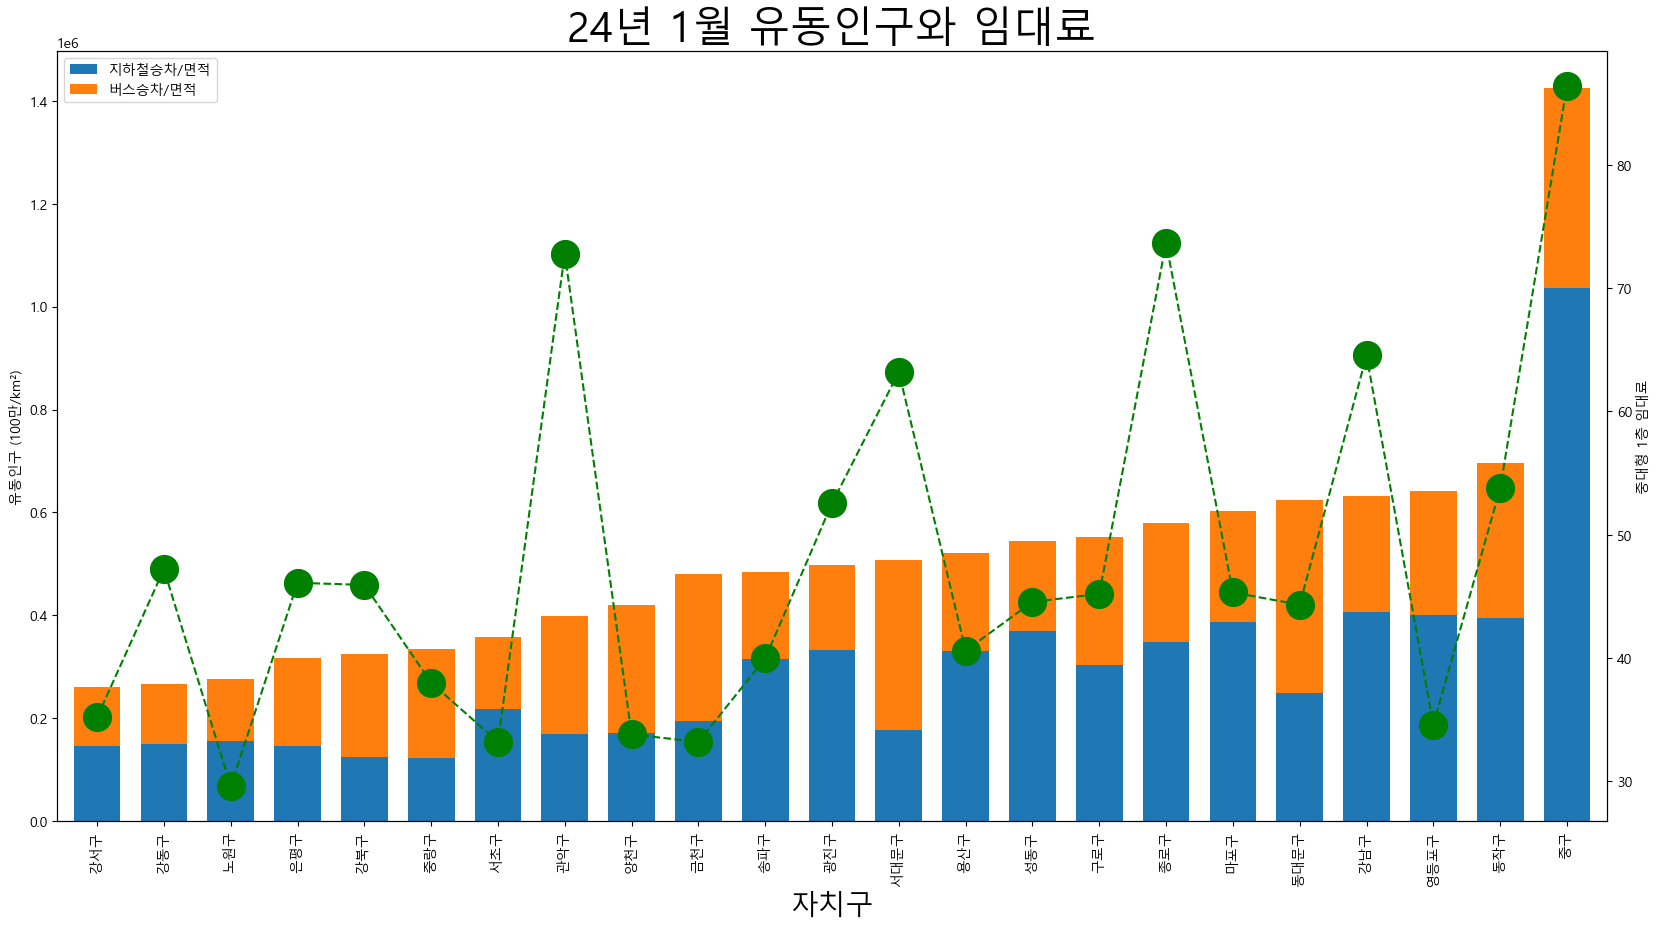

In [78]:
ax1 = fluid_combined[["지하철승차/면적", "버스승차/면적"]].plot(kind = "bar", figsize = (20, 10), width = 0.7, stacked = True)
ax2 = ax1.twinx() # 원래 주어진 axis, x를 공유하는 쌍둥이 axis
ax2.plot(fluid_combined.index, fluid_combined["중대형"], ls = ("--"), marker = "o", markersize = 20, color = "green", label = "중대형 1층 임대료")

# ax1.set_ylim(0, 500)
# ax2.set_ylim(-50, 50)

ax1.set_xlabel("자치구", size = 20)
ax1.set_ylabel("유동인구 (100만/km²)")
ax2.set_ylabel("중대형 1층 임대료")

plt.title("24년 1월 유동인구와 임대료", size = 30)
ax1.legend(loc = "upper left")

plt.show()

In [79]:
fluid_combined = fluid_combined.sort_index()

In [81]:
fluid_combined.to_csv("./유동인구종합.csv")

In [80]:
fluid_combined["종합/면적"] = fluid_combined["종합승차/면적"] + fluid_combined["종합하차/면적"]

In [82]:
fluid_combined

,중대형,소형,면적,지하철승차,지하철하차,지하철승차/면적,지하철하차/면적,버스승차,버스하차,버스승차/면적,버스하차/면적,종합승차/면적,종합하차/면적,종합/면적
자치구,,,,,,,,,,,,,,
강남구,64.54,64.67,39.50,16064323,16609933,406692.0,420505.0,8866092,8441292,224458.0,213704.0,631150.0,634208.0,1265358.0
강동구,47.20,56.10,24.59,3687342,3557783,149953.0,144684.0,2863138,2789010,116435.0,113420.0,266388.0,258105.0,524493.0
강북구,45.93,42.60,23.60,2964721,2920052,125624.0,123731.0,4718950,4588938,199956.0,194447.0,325579.0,318178.0,643757.0
강서구,35.20,28.70,41.45,6074290,5870376,146545.0,141625.0,4740481,4696688,114366.0,113310.0,260911.0,254935.0,515846.0
관악구,72.80,65.75,29.57,5009488,4864323,169411.0,164502.0,6779508,6830265,229270.0,230986.0,398681.0,395488.0,794169.0
광진구,52.55,39.40,17.06,5662045,5555724,331890.0,325658.0,2847062,2858562,166885.0,167559.0,498775.0,493217.0,991992.0
구로구,45.20,47.10,20.12,6100868,6022382,303224.0,299323.0,5010540,4786098,249033.0,237878.0,552257.0,537201.0,1089458.0
금천구,33.20,31.20,13.02,2528962,2610915,194237.0,200531.0,3732466,3584678,286672.0,275321.0,480908.0,475852.0,956760.0
노원구,29.60,26.00,35.44,5549462,5408404,156588.0,152607.0,4235957,4127188,119525.0,116456.0,276112.0,269063.0,545175.0


## 데이터베이스에 삽입

In [83]:
fluid_combined2 = fluid_combined.reset_index().iloc[:, [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]

In [84]:
fluid_combined2

,자치구,지하철승차,지하철하차,지하철승차/면적,지하철하차/면적,버스승차,버스하차,버스승차/면적,버스하차/면적,종합승차/면적,종합하차/면적,종합/면적
0,강남구,16064323,16609933,406692.0,420505.0,8866092,8441292,224458.0,213704.0,631150.0,634208.0,1265358.0
1,강동구,3687342,3557783,149953.0,144684.0,2863138,2789010,116435.0,113420.0,266388.0,258105.0,524493.0
2,강북구,2964721,2920052,125624.0,123731.0,4718950,4588938,199956.0,194447.0,325579.0,318178.0,643757.0
3,강서구,6074290,5870376,146545.0,141625.0,4740481,4696688,114366.0,113310.0,260911.0,254935.0,515846.0
4,관악구,5009488,4864323,169411.0,164502.0,6779508,6830265,229270.0,230986.0,398681.0,395488.0,794169.0
5,광진구,5662045,5555724,331890.0,325658.0,2847062,2858562,166885.0,167559.0,498775.0,493217.0,991992.0
6,구로구,6100868,6022382,303224.0,299323.0,5010540,4786098,249033.0,237878.0,552257.0,537201.0,1089458.0
7,금천구,2528962,2610915,194237.0,200531.0,3732466,3584678,286672.0,275321.0,480908.0,475852.0,956760.0
8,노원구,5549462,5408404,156588.0,152607.0,4235957,4127188,119525.0,116456.0,276112.0,269063.0,545175.0
9,동대문구,3546173,3492749,249379.0,245622.0,5338922,5231785,375452.0,367917.0,624831.0,613540.0,1238371.0


In [12]:
employee_data = pd.read_csv("C:/Users/ITSC/Desktop/MiniPrj2/Git/Data/employee_data.csv")

In [13]:
employee_data2 = employee_data[employee_data["자치구"].isin(seoul_district["자치구"])].reset_index(drop = True)

In [14]:
employee_data2 = employee_data2.iloc[:, [0, 2, 1, 5, 4, 6, 7]]

In [15]:
employee_data2.sort_values(by = "자치구").reset_index(drop = True)

,자치구,종사자수,사업체수,종사자밀도(A),사업체밀도,인구밀도(B),종사자밀도비(A/B*100)
0,강남구,801419,110007,20290.37,2785.16,13616.05,149.02
1,강동구,157465,41660,6403.49,1694.15,18969.61,33.76
2,강북구,80222,26385,3399.17,1117.99,12820.23,26.51
3,강서구,290473,58806,7007.42,1418.65,13986.42,50.10
4,관악구,128417,37915,4343.06,1282.28,16891.36,25.71
5,광진구,129707,33706,7601.65,1975.39,20666.18,36.78
6,구로구,240689,52791,11963.21,2623.92,20933.49,57.15
7,금천구,255449,47964,19619.01,3683.73,18808.14,104.31
8,노원구,133398,37909,3764.14,1069.69,14530.40,25.91
9,동대문구,146383,42813,10297.20,3011.65,24761.59,41.59


In [21]:
seoul_district = seoul_district.iloc[:, 1:]

In [22]:
seoul_district

,자치구,중대형 지하1층,중대형 1층,중대형 2층,중대형 3층,중대형 4층,중대형 5층,중대형 6-10층,소형 지하1층,소형 1층,소형 2층,면적 (km²)
0,강남구,22.13,64.54,32.00,25.54,23.36,22.50,21.64,29.43,64.67,33.71,39.50
1,강동구,11.10,47.20,20.50,15.20,13.50,12.00,12.10,0.00,56.10,24.70,24.59
2,강북구,13.17,45.93,18.90,15.43,12.50,12.93,14.33,13.00,42.60,17.80,23.60
3,강서구,10.70,35.20,16.30,14.80,12.30,10.10,9.00,6.20,28.70,13.60,41.45
4,관악구,18.40,72.80,28.90,21.95,19.65,21.25,18.05,13.80,65.75,30.85,29.57
5,광진구,14.30,52.55,22.80,16.45,15.25,12.95,13.70,16.05,39.40,20.75,17.06
6,구로구,11.70,45.20,18.80,13.00,11.70,9.10,0.00,0.00,47.10,28.30,20.12
7,금천구,11.70,33.20,14.10,10.60,9.30,11.40,0.00,0.00,31.20,13.20,13.02
8,노원구,8.40,29.60,14.40,12.20,10.90,12.10,0.00,10.00,26.00,9.80,35.44
9,동대문구,11.38,44.32,18.10,13.70,12.58,12.10,7.70,8.72,42.40,19.38,14.22


In [252]:
insert_query = """INSERT INTO analysis_data_districtdata("district_name", "large_b1_rent", "large_1_rent", "large_2_rent", "large_3_rent", "large_4_rent", "large_5_rent", "large_6to10_rent", "small_b1_rent", "small_1_rent", "small_2_rent", "district_size") VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"""
data = tuple(seoul_district.iloc[0, :])

conn = sqlite3.connect("C:/Users/ITSC/Desktop/MiniPrj2/Git/web/db.sqlite3")
cur = conn.cursor()
cur.execute(insert_query, data)
cur.close()
conn.commit()
conn.close()

In [23]:
insert_query = """INSERT INTO analysis_data_districtdata("district_name", "large_b1_rent", "large_1_rent", "large_2_rent", "large_3_rent", "large_4_rent", "large_5_rent", "large_6to10_rent", "small_b1_rent", "small_1_rent", "small_2_rent", "district_size") VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"""


for i in range(0,len(seoul_district)):
    data = tuple(seoul_district.iloc[i, :])
    
    conn = sqlite3.connect("C:/Users/ITSC/Desktop/MiniPrj2/Git/web/db.sqlite3")
    cur = conn.cursor()
    cur.execute(insert_query, data)
    cur.close()
    conn.commit()
    conn.close()

In [249]:
data = tuple(seoul_district.iloc[0, :])

In [20]:
for i in range(0,len(employee_data2)):
    data = tuple(employee_data2.iloc[i, :])
    
    conn = sqlite3.connect("C:/Users/ITSC/Desktop/MiniPrj2/Git/web/db.sqlite3")
    cur = conn.cursor()
    cur.execute(insert_query2, data)
    cur.close()
    conn.commit()
    conn.close()

In [19]:
insert_query2 = """INSERT INTO analysis_data_employeedata("district_id_id", "employee_count", "company_count", "employee_density", "company_density", "population_density", "employee_ratio") VALUES(?, ?, ?, ?, ?, ?, ?)"""

In [291]:
pd.Series(employee_data2.index+1)

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
dtype: int64

In [16]:
employee_data2["자치구_id"] = pd.Series(employee_data2.index+1)

In [17]:
employee_data2 = employee_data2.iloc[:, [7, 1, 2, 3, 4, 5, 6]]

In [18]:
employee_data2

,자치구_id,종사자수,사업체수,종사자밀도(A),사업체밀도,인구밀도(B),종사자밀도비(A/B*100)
0,1,275063,48361,11502.69,2022.38,6431.21,178.86
1,2,386564,70308,38810.63,7058.85,13231.28,293.32
2,3,152605,29680,6979.05,1357.35,10851.71,64.31
3,4,203221,41665,12053.51,2471.25,17359.06,69.44
4,5,129707,33706,7601.65,1975.39,20666.18,36.78
5,6,146383,42813,10297.20,3011.65,24761.59,41.59
6,7,113144,39310,6117.35,2125.37,21188.03,28.87
7,8,80222,26385,3399.17,1117.99,12820.23,26.51
8,9,133398,37909,3764.14,1069.69,14530.40,25.91
9,10,109031,36509,3669.78,1228.82,16060.74,22.85


In [85]:
fluid_combined3 = fluid_combined2.reset_index().iloc[:, [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]

In [87]:
fluid_combined3["index"] = fluid_combined3["index"] + 1

In [88]:
fluid_combined3

,index,지하철승차,지하철하차,지하철승차/면적,지하철하차/면적,버스승차,버스하차,버스승차/면적,버스하차/면적,종합승차/면적,종합하차/면적,종합/면적
0,1,16064323,16609933,406692.0,420505.0,8866092,8441292,224458.0,213704.0,631150.0,634208.0,1265358.0
1,2,3687342,3557783,149953.0,144684.0,2863138,2789010,116435.0,113420.0,266388.0,258105.0,524493.0
2,3,2964721,2920052,125624.0,123731.0,4718950,4588938,199956.0,194447.0,325579.0,318178.0,643757.0
3,4,6074290,5870376,146545.0,141625.0,4740481,4696688,114366.0,113310.0,260911.0,254935.0,515846.0
4,5,5009488,4864323,169411.0,164502.0,6779508,6830265,229270.0,230986.0,398681.0,395488.0,794169.0
5,6,5662045,5555724,331890.0,325658.0,2847062,2858562,166885.0,167559.0,498775.0,493217.0,991992.0
6,7,6100868,6022382,303224.0,299323.0,5010540,4786098,249033.0,237878.0,552257.0,537201.0,1089458.0
7,8,2528962,2610915,194237.0,200531.0,3732466,3584678,286672.0,275321.0,480908.0,475852.0,956760.0
8,9,5549462,5408404,156588.0,152607.0,4235957,4127188,119525.0,116456.0,276112.0,269063.0,545175.0
9,10,3546173,3492749,249379.0,245622.0,5338922,5231785,375452.0,367917.0,624831.0,613540.0,1238371.0


In [91]:
fluid_combined3.to_csv("./유동인구종합.csv")

In [89]:
insert_query3 = """INSERT INTO analysis_data_floatpopdata("district_id_id", "subway_in", "subway_out", "bus_in", "bus_out", "subway_in_ratio", "subway_out_ratio", "bus_in_ratio", "bus_out_ratio", "combined_in_ratio", "combined_out_ratio", "total_ratio") VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"""

In [ ]:
("district_id", "subway_in", "subway_out", "bus_in", "bus_out", "subway_in_ratio", "subway_out_ratio", "bus_in_ratio", "bus_out_ratio", "combined_in_ratio", "combined_out_ratio", "total_ratio")

In [90]:
for i in range(0,len(fluid_combined3)):
    data = tuple(fluid_combined3.iloc[i, :])
    
    conn = sqlite3.connect("C:/Users/ITSC/Desktop/MiniPrj2/Git/web/db.sqlite3")
    cur = conn.cursor()
    cur.execute(insert_query3, data)
    cur.close()
    conn.commit()
    conn.close()

In [ ]:
insert_query3 = """INSERT INTO analysis_data_floatpopdata("district_id_id", "subway_in", "subway_out", "bus_in", "bus_out", "subway_in_ratio", "subway_out_ratio", "bus_in_ratio", "bus_out_ratio", "combined_in_ratio", "combined_out_ratio", "total_ratio") VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"""
for i in range(0,len(fluid_combined3)):
    data = tuple(fluid_combined3.iloc[i, :])
    
    conn = sqlite3.connect("C:/Users/ITSC/Desktop/MiniPrj2/Git/web/db.sqlite3")
    cur = conn.cursor()
    cur.execute(insert_query3, data)
    cur.close()
    conn.commit()
    conn.close()

## 결론 내리기

In [12]:
fluid_combined3 = pd.read_csv("C:/Users/ITSC/Desktop/MiniPrj2/Git/Data/유동인구종합.csv")

In [16]:
fluid_combined3 = fluid_combined3.iloc[:, 2:].reset_index()

In [26]:
fluid_combined3.iloc[:, [0, 11]]

,index,종합/면적
0,0,1265358.0
1,1,524493.0
2,2,643757.0
3,3,515846.0
4,4,794169.0
5,5,991992.0
6,6,1089458.0
7,7,956760.0
8,8,545175.0
9,9,1238371.0


In [24]:
seoul_district = seoul_district.iloc[:, [0, 1, 3, 10, 12]]

In [25]:
seoul_district

,index,자치구,중대형 1층,소형 1층,면적 (km²)
0,0,강남구,64.54,64.67,39.50
1,1,강동구,47.20,56.10,24.59
2,2,강북구,45.93,42.60,23.60
3,3,강서구,35.20,28.70,41.45
4,4,관악구,72.80,65.75,29.57
5,5,광진구,52.55,39.40,17.06
6,6,구로구,45.20,47.10,20.12
7,7,금천구,33.20,31.20,13.02
8,8,노원구,29.60,26.00,35.44
9,9,동대문구,44.32,42.40,14.22


In [28]:
final_df = pd.merge(seoul_district, fluid_combined3.iloc[:, [0, 11]], on = "index", how = "inner")

In [46]:
final_df.drop(21)

,index,자치구,중대형 1층,소형 1층,면적 (km²),종합/면적
0,0,강남구,64.54,64.67,39.50,1265358.0
1,1,강동구,47.20,56.10,24.59,524493.0
2,2,강북구,45.93,42.60,23.60,643757.0
3,3,강서구,35.20,28.70,41.45,515846.0
4,4,관악구,72.80,65.75,29.57,794169.0
5,5,광진구,52.55,39.40,17.06,991992.0
6,6,구로구,45.20,47.10,20.12,1089458.0
7,7,금천구,33.20,31.20,13.02,956760.0
8,8,노원구,29.60,26.00,35.44,545175.0
9,9,동대문구,44.32,42.40,14.22,1238371.0


In [31]:
# Min-Max 정규화 객체 생성
scaler = MinMaxScaler()

In [ ]:
# 데이터 정규화
scaled_data = scaler.fit_transform(data)

In [47]:
final_scaled = pd.DataFrame(scaler.fit_transform(final_df.drop(21).iloc[:, 2:]))

In [48]:
final_scaled = final_scaled.iloc[:, [0, 1, 3]]

In [49]:
final_scaled["자치구"] = final_df["자치구"]

In [50]:
final_scaled = final_scaled.rename(columns = {0 : "중대형 1층", 1 : "소형 1층", 3 : "유동인구/면적"})

In [52]:
final_scaled

,중대형 1층,소형 1층,유동인구/면적,자치구
0,0.792830,0.931134,0.862087,강남구
1,0.399365,0.724777,0.009946,강동구
2,0.370547,0.399711,0.147123,강북구
3,0.127071,0.065013,0.000000,강서구
4,0.980259,0.957139,0.320126,관악구
5,0.520762,0.322658,0.547662,광진구
6,0.353982,0.508066,0.659767,구로구
7,0.081688,0.125211,0.507138,금천구
8,0.000000,0.000000,0.033734,노원구
9,0.334014,0.394895,0.831046,동대문구
